### Importación de bibliotecas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from operator import itemgetter

### Inicialización del sistema

In [4]:
lamb = 1/300
num_onu = 15             # Cantidad de ONUs
ancho_banda_total = 2488.0  # Según ancho de banda por cable GPON 2.488 Gb/s de downstream
lat_min = 20.0              # Latencia mínima
lat_max = 100.0             # Latencia máxima
utility = np.zeros(num_onu, dtype=int)
tasa_exito = np.zeros(num_onu, dtype=int)
package = 15000 #largo de un paquete de datos en bits
distancias = np.random.randint(5, 40, size=num_onu)
canal = 50

### Inicialización del sistema - Valores de media de demandas de ONU y su varianza

In [5]:
mu = np.log(200**2 / np.sqrt(20**2 + 200**2))
sigma = np.sqrt(np.log(1 + (20**2 / 200**2)))

### Algoritmo DBA

In [6]:
def dba():
    demandas_onu = np.random.lognormal(mu, sigma, num_onu)
    posicion_max = np.argmax(demandas_onu)  # Para saber cuál ONU es la que tiene mayor demanda
    demanda_total = np.sum(demandas_onu)
    if demanda_total > ancho_banda_total: 
        variacion = np.random.uniform(0.7, 1.3, num_onu)  # Variable para variar las asignaciones
        asignaciones = (demandas_onu / demanda_total) * ancho_banda_total * variacion
        asignaciones = (asignaciones / np.sum(asignaciones)) * ancho_banda_total
    else:
        asignaciones = demandas_onu
    asignaciones = np.minimum(asignaciones, demandas_onu)

    # Manejo de latencias del sistema
    latencias = (demandas_onu / asignaciones) * lat_min + 1 + np.random.uniform(0.1, 1.0, num_onu) # calculo de latencias por procesamiento, cola, uso de algortimo, y adicion de retransmision
    latencias = latencias + distancias/200000 # considera latencia por distancia

    # Manejo de utilidad de cada ONU dependiendo de la mayor demanda
    utility[posicion_max] += 1  # Sumar 1 al índice de mayor demanda

    # Manejo de la pérdida de paquetes
    paquetes_transmitidos = asignaciones / package
    paquetes_demandados = demandas_onu / package
    perdidas_paquetes = ((paquetes_demandados - paquetes_transmitidos) / paquetes_demandados) *100
    return latencias, perdidas_paquetes

### Calendarización y evento de downstream para llamada de algortimo DBA

In [7]:
def schedule_a(val, t_a):
    # Se agrega el nuevo elemento de calendarización
    t_a.append(val)
    t_a.sort()

def InputEvent(t_a):
    a = np.random.exponential(lamb)
    schedule_a(t_a[0] + a, t_a)
    latencias, perdidas_paquetes = dba()
    i = 0
    for lat in latencias:
        if lat <= lat_max:
            tasa_exito[i] += 1
        i +=1
    t_a.pop(0)
    return latencias, perdidas_paquetes

### Calendarización y evento de upstream para probabilidad de bloqueo

In [8]:
def get_id(range):
    id = rd.choice(list(range))
    return id
def fel_users_init(rango,tasa):
    Lista = []
    for i in rango:
        Lista.append((i, 0, np.random.exponential(tasa))) ##INICIALIZAR FEL
    Lista.sort(key=itemgetter(2))
    return Lista
def next_event(FEL):
    if FEL:
        return FEL[0]
    else:
        return None
def schedule_User(FEL, time, id, type):    ### CALENDERIZAR
    FEL.append((id, type, time))
    FEL.sort(key=itemgetter(2))
    return FEL

### Métricas que muestran latencias y probabilidad de pérdidas de paquetes

In [9]:
def metricas(promedios_latencias,promedios_perdida,probabilidad_bloqueo):
    for onu in range(num_onu):
        plt.plot(promedios_latencias[:, onu], label=f'ONU {onu + 1}')
    plt.xlabel('Legadas (10^6)')
    plt.ylabel('Latencia Promedio (ms)')
    plt.title('Latencia Promedio de cada ONU por Llegadas/10')
    plt.legend(loc='right')
    plt.show()
    for onu in range(num_onu):
        plt.plot(promedios_perdida[:, onu], label=f'ONU {onu + 1}')
    plt.xlabel('Llegadas (10^6)')
    plt.ylabel('Pérdida Promedio de Paquetes (%)')
    plt.title('Pérdida Promedio de Paquetes de cada ONU por Llegadas/10')
    plt.legend(loc='right')
    plt.show()

    plt.plot(probabilidad_bloqueo, label='Probabilidad de Bloqueo')
    plt.xlabel('Llegadas (10^6)')
    plt.ylabel('Probabilidad de Bloqueo (%)')
    plt.title('Probabilidad de Bloqueo por Llegadas/10^6')
    plt.legend(loc='right')
    plt.show()

### Estructura de simulador completo

In [10]:
def simulacion():
    llegadas = 0
    t_a = []
    u=0
    b=0
    t_a.append(np.random.exponential(lamb))
    latencias_totales = np.zeros(num_onu)
    perdidas_totales = np.zeros(num_onu)
    promedios_latencias = []
    promedios_perdida = []
    probabilidades_bloqueo = []
    usuarios_por_onu = np.random.randint(1, 15, size=num_onu)
    users_total = sum(usuarios_por_onu)
    canal = users_total-15
    rango = range(0,15)
    lista_users=fel_users_init(rango,lamb)
    
    while llegadas < 10**7:
        latencias,perdida = InputEvent(t_a)
        latencias_totales += latencias
        perdidas_totales += perdida
        evento = next_event(lista_users)
        if evento:
            id, event_type, current_time = evento
            lista_users.pop(0)
            if event_type == 0:
                if u < canal:
                    u += 1
                    service_time = np.random.exponential(mu) + current_time 
                    lista_users = schedule_User(lista_users,service_time,id,1)
                    next_id=get_id(rango)
                    access_time = np.random.exponential(lamb) + current_time
                    lista_users = schedule_User(lista_users,access_time,next_id,0)
                    llegadas += 1
                    
                else: 
                    next_id=get_id(rango)
                    access_time = np.random.exponential(mu) + current_time
                    lista_users = schedule_User(lista_users,access_time,next_id,0)
                    b += 1
                    llegadas += 1
            if event_type == 1:
                u -= 1
                llegadas += 1
        else:
            break  
        if llegadas % 10**6 == 0:
            promedio_latencia = latencias_totales / 10**6
            promedios_latencias.append(promedio_latencia.copy())
            latencias_totales = np.zeros(num_onu)
            promedio_perdida = perdidas_totales / 10**6
            promedios_perdida.append(promedio_perdida.copy())
            perdidas_totales = np.zeros(num_onu)
            block_probability = (b / llegadas) * 100
            probabilidades_bloqueo.append(block_probability)
        
       
    promedios_latencias = np.array(promedios_latencias)
    promedio_perdida = np.array(promedios_perdida)
    print("La ONU con mayor demanda es: ",np.argmax(utility)+1)
    print("La ONU con menor demanda es: ",np.argmin(utility)+1)
    print("Se muestra la lista por máximo de demanda por iteración de cada ONU: ",utility)
    print("Se muestra la lista con las tasas de exito en cuanto a latencia de cada ONU en porcentaje: ",tasa_exito/10**4)
    metricas(promedios_latencias,promedio_perdida,probabilidades_bloqueo)

La ONU con mayor demanda es:  15
La ONU con menor demanda es:  7
Se muestra la lista por máximo de demanda por iteración de cada ONU:  [666119 667042 667067 666846 665814 667460 665746 667550 666308 665871
 666238 667116 667087 665942 667794]
Se muestra la lista con las tasas de exito en cuanto a latencia de cada ONU en porcentaje:  [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000.]


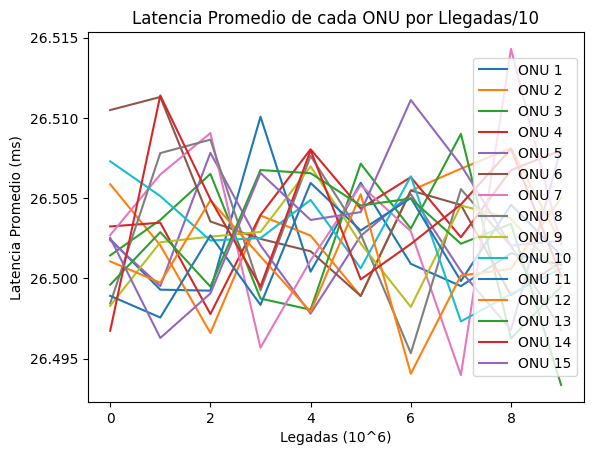

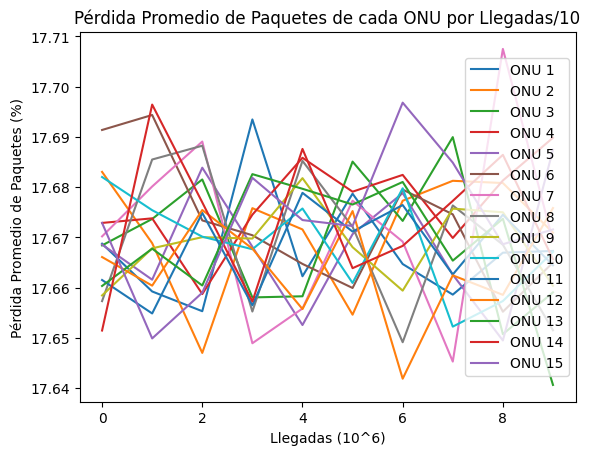

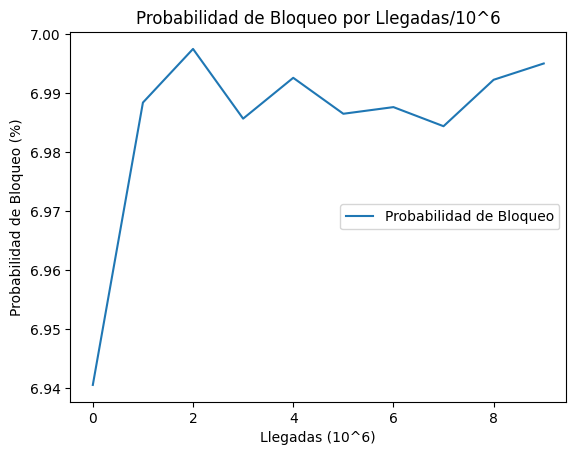

In [11]:
simulacion()